In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from esc_psf.math_module import xp, xcipy, ensure_np_array
from esc_psf import utils, wfe
import esc_psf.esc_fraunhofer as esc

wavelength_c = 650e-9

/home/kianmilani/miniconda3/envs/km311env/lib/python3.11/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
2025-05-28 09:35:05,639	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


SCoOB interface does not have the required packages to operate.


In [44]:
reload(esc)
M = esc.single(
    Nact=34,
    total_pupil_diam=3.0,
    dm_beam_diam=9.2e-3,
    act_spacing=300e-6, 
)

# M = esc.single(
#     Nact=48,
#     total_pupil_diam=3.0,
#     dm_beam_diam=9.2e-3*48/34,
#     act_spacing=300e-6, 
# )


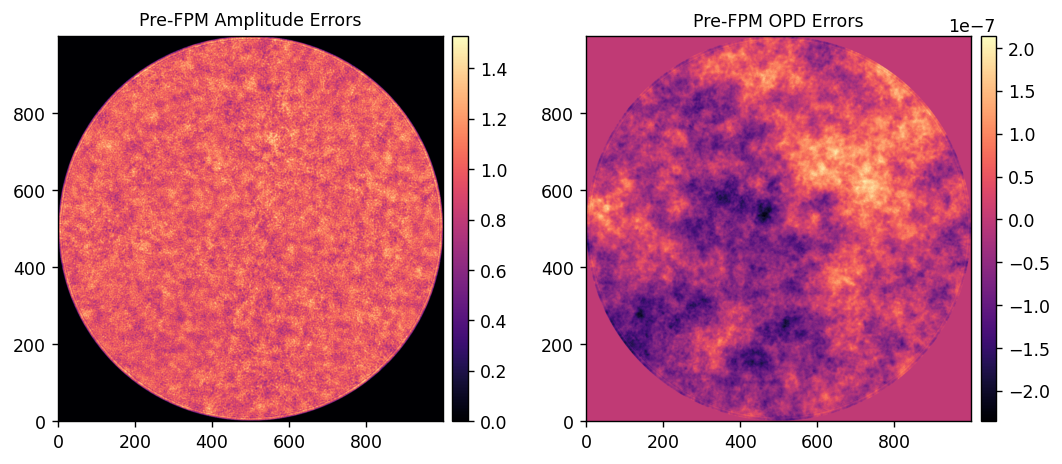

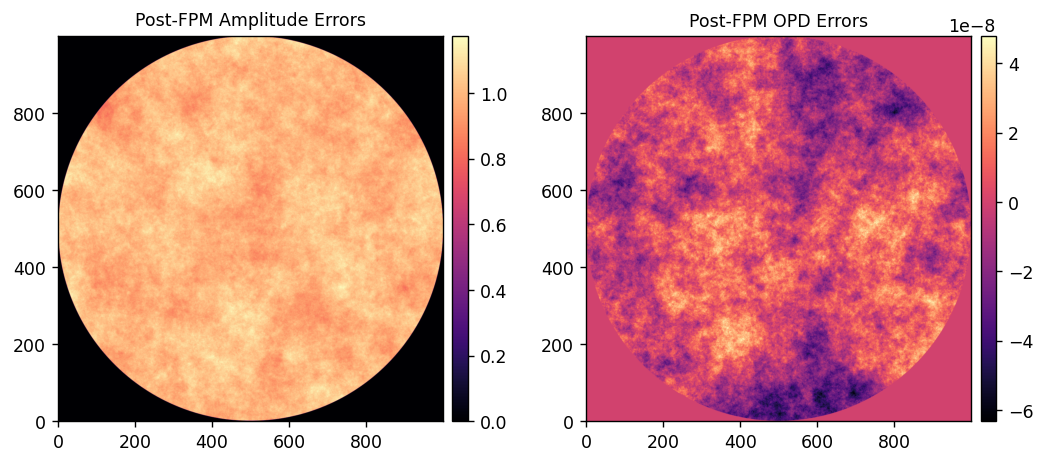

2.8968216282522213e-08


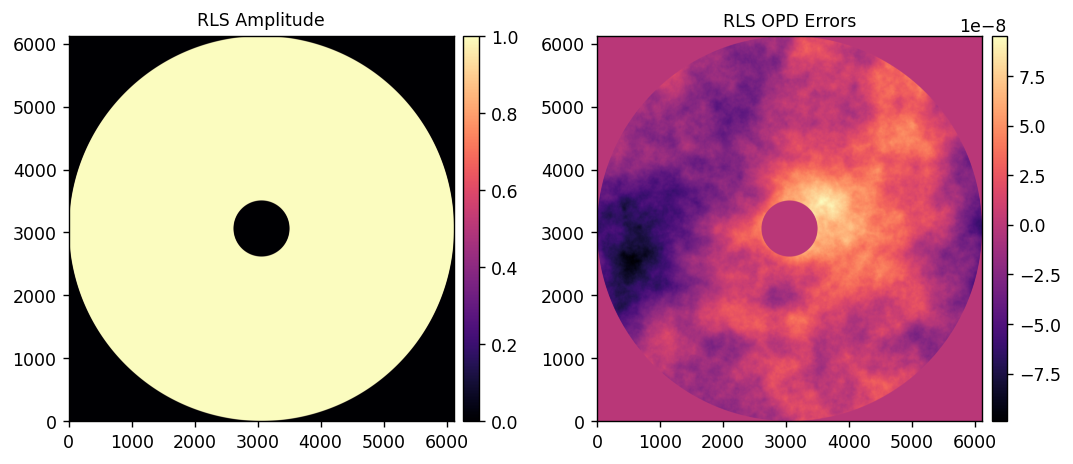

In [45]:
reload(wfe)
npix = 1000

# prefpm_slope = 2.25
# prefpm_opd_rms = 35*u.nm
# prefpm_amp_rms = 0.075
# prefpm_wfe_amp, prefpm_wfe_opd = wfe.generate_wfe(
#     npix=M.npix, 
#     oversample=1,
#     wavelength=M.wavelength_c,
#     opd_index=prefpm_slope, amp_index=prefpm_slope,
#     opd_rms=prefpm_opd_rms, 
#     amp_rms=prefpm_amp_rms,
#     remove_amp_modes=12,
#     remove_opd_modes=3,
#     opd_seed=12, 
#     amp_seed=123,
# )
prefpm_wfe_amp = utils.load_fits('../data/prefpm_amp.fits')
prefpm_wfe_opd = utils.load_fits('../data/prefpm_opd.fits')
utils.imshow(
    [prefpm_wfe_amp, prefpm_wfe_opd],
    titles=['Pre-FPM Amplitude Errors', 'Pre-FPM OPD Errors'],
)

postfpm_slope = 2.5
postfpm_opd_rms = 15*u.nm
postfpm_amp_rms = 0.05
postfpm_wfe_amp, postfpm_wfe_opd = wfe.generate_wfe(
    npix=M.npix, 
    oversample=1,
    wavelength=M.wavelength_c,
    opd_index=postfpm_slope, amp_index=postfpm_slope,
    opd_rms=postfpm_opd_rms, 
    amp_rms=postfpm_amp_rms,
    remove_amp_modes=12,
    remove_opd_modes=3,
    opd_seed=1234, 
    amp_seed=12345,
)
utils.imshow(
    [postfpm_wfe_amp, postfpm_wfe_opd], 
    titles=['Post-FPM Amplitude Errors', 'Post-FPM OPD Errors'],
)

rls_slope = 3.5
rls_opd_rms = 30*u.nm
rls_wfe_amp, rls_wfe_opd = wfe.generate_wfe(
    npix=M.npix_rls, 
    oversample=1,
    wavelength=M.wavelength_c,
    opd_index=rls_slope, amp_index=rls_slope,
    opd_rms=rls_opd_rms, 
    amp_rms=0.0,
    remove_amp_modes=0,
    remove_opd_modes=0,
    opd_seed=123456, 
    amp_seed=1234567,
)

rls_mask = utils.pad_or_crop(M.RLS, M.npix_rls) > 0
rls_wfe_amp *= utils.pad_or_crop(M.RLS, M.npix_rls)
rls_wfe_opd *= utils.pad_or_crop(M.RLS, M.npix_rls)
rls_wfe_opd_rms = xp.sqrt( xp.mean( xp.square( rls_wfe_opd[rls_mask] )))
print(rls_wfe_opd_rms)
rls_wfe_opd *= rls_opd_rms.to_value(u.m) / rls_wfe_opd_rms
rls_wfe_opd = xp.rot90(rls_wfe_opd)
utils.imshow(
    [rls_wfe_amp, rls_wfe_opd], 
    titles=['RLS Amplitude', 'RLS OPD Errors'],
)

In [46]:
reload(esc)
M.PREFPM_AMP = prefpm_wfe_amp
M.PREFPM_OPD = prefpm_wfe_opd 

M.POSTFPM_AMP = postfpm_wfe_amp
M.POSTFPM_OPD = postfpm_wfe_opd 

# M.RLS_AMP = rls_wfe_amp
# M.RLS_OPD = rls_wfe_opd 


1.0
(952,) <class 'numpy.ndarray'>


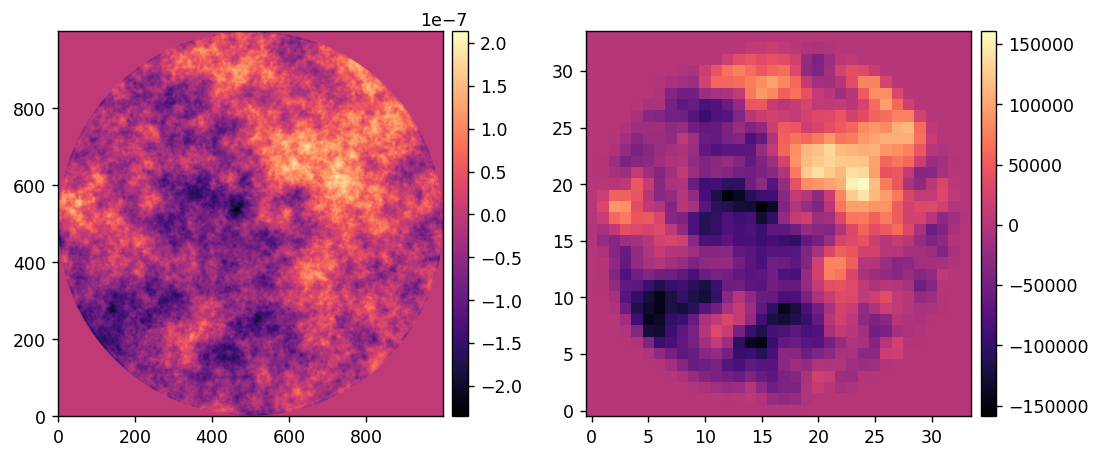

In [47]:
def val_and_grad(
        del_acts, 
        M, 
        current_acts=np.zeros((M.Nact,M.Nact)) 
    ):

    del_acts = xp.array(del_acts)
    del_command = xp.zeros((M.Nact, M.Nact))
    del_command[M.dm_mask] = xp.array(del_acts)

    current_acts = xp.array(current_acts)

    dm_command = current_acts + del_command
    dm_mft = M.Mx@dm_command@M.My
    dm_surf_fft = M.inf_fun_fft * dm_mft
    dm_surf = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(dm_surf_fft,))).real
    dm_surf = utils.pad_or_crop(dm_surf, M.npix)

    OPD = xp.array(M.PREFPM_OPD)
    OPD_MASK = utils.pad_or_crop(M.BAP_MASK, OPD.shape[0])
    opd_l2norm = OPD[OPD_MASK].dot(OPD[OPD_MASK])
    total_opd =  OPD + 2*dm_surf
    J = total_opd[OPD_MASK].dot(total_opd[OPD_MASK]) / opd_l2norm
    print(J)

    masked_total = OPD_MASK * total_opd
    dJ_dOPD = 2 * (masked_total) / opd_l2norm

    dJ_dS_DM = utils.pad_or_crop(dJ_dOPD, M.Nsurf)
    x2_bar = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dS_DM)))
    x1_bar = x2_bar * M.inf_fun_fft.conj()
    dJ_dA1 = M.Mx_back@x1_bar@M.My_back / ( M.Nsurf * M.Nact * M.Nact )

    dJ_dA = dJ_dA1[M.dm_mask].real

    return ensure_np_array(J), ensure_np_array(dJ_dA)

del_acts = xp.zeros(M.Nacts)
J0, dJ_dA = val_and_grad(del_acts, M)
print(dJ_dA.shape, type(dJ_dA))

dm_grad = xp.zeros((M.Nact, M.Nact))
dm_grad[M.dm_mask] = xp.array(dJ_dA)
utils.imshow([M.PREFPM_OPD, dm_grad])

1.0
3407075289963.6943
0.637394248593494
0.15236028129615298
0.13983142470661475
0.12427919086128304
0.1222535158533819
0.1207521857354525
0.12008195190742413
0.1196364060820518
0.11948991308336657
0.119043643129769
0.11897047937327426


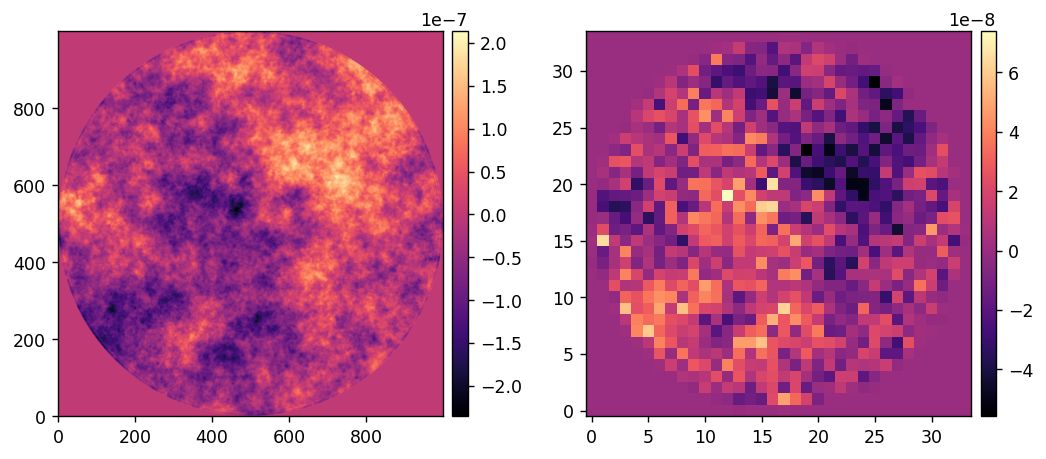

In [48]:
bfgs_tol = 1e-4
options = {
    'disp':True, 
    # 'maxiter':30,
    # 'maxls':100, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
}
del_acts0 = np.zeros(M.Nacts)
res = minimize(
    val_and_grad, 
    jac=True, 
    x0=del_acts0, 
    args=(M),
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=options,
)

flat_command = xp.zeros((M.Nact, M.Nact))
flat_command[M.dm_mask] = xp.array(res.x)
utils.imshow([M.PREFPM_OPD, flat_command],)

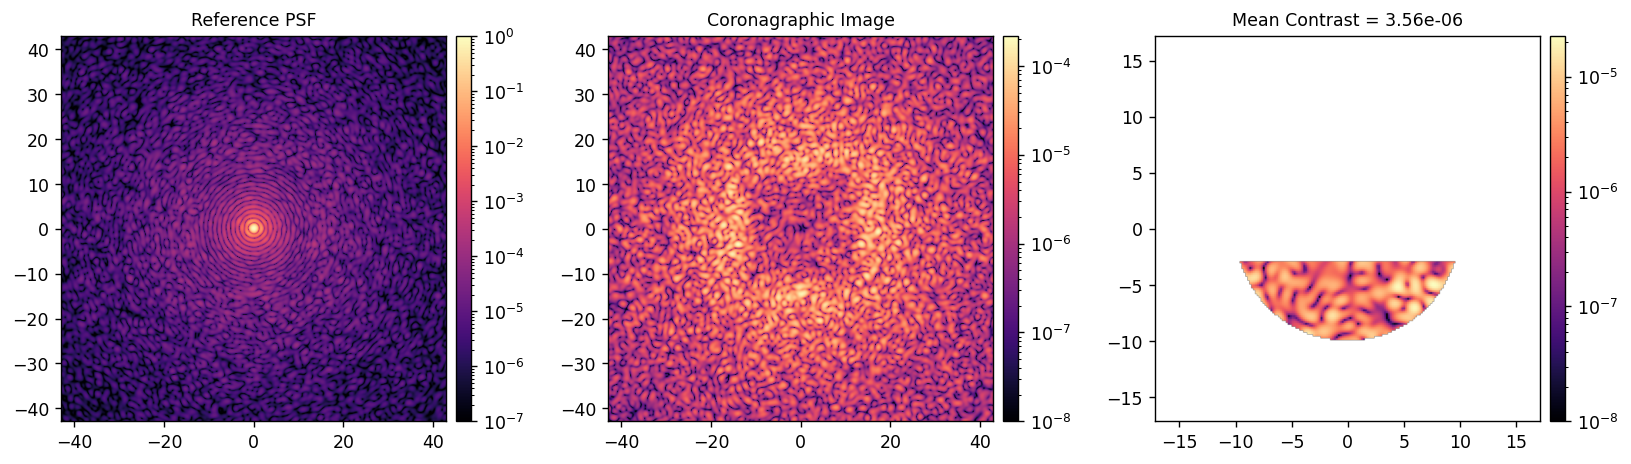

In [49]:
reload(esc)
reload(utils)

dm_flat_noise = 0e-9

M.PREFPM_AMP = prefpm_wfe_amp
M.PREFPM_OPD = prefpm_wfe_opd 
M.POSTFPM_AMP = postfpm_wfe_amp
M.POSTFPM_OPD = postfpm_wfe_opd 
M.RLS_AMP = rls_wfe_amp
M.RLS_OPD = rls_wfe_opd

M.dm_ref = flat_command + dm_flat_noise*xp.random.randn(M.Nact, M.Nact)*M.dm_mask
M.reset_dm()

iwa = 3
owa = 10
control_mask = utils.create_annular_focal_plane_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    rotation=90,
)

M.Imax_ref = 1
M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
camsci_im0 = M.snap_camsci()
mean_contrast = xp.mean(camsci_im0[control_mask])

utils.imshow(
    [ref_psf/M.Imax_ref, camsci_im0, camsci_im0*control_mask],
    titles=['Reference PSF', 'Coronagraphic Image', f'Mean Contrast = {mean_contrast:.2e}'], 
    pxscls=3*[M.camsci_pxscl_lamDc],
    norms=[LogNorm(1e-7), LogNorm(1e-8), LogNorm(1e-8)],
    npix=[None, None, 200],
)

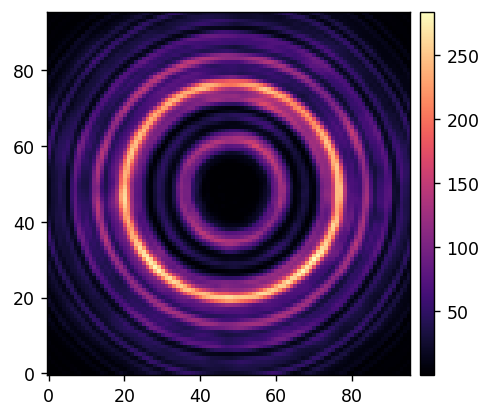

In [41]:
# M.ncamlo = 128
# M.ncamlo = 256
# M.llowfsc_defocus = 2.75e-3
camlo_im0 = M.snap_camlo()
utils.imshow([camlo_im0])

In [18]:
M.camsci_pxscl_lamDc, M.ncamsci

(0.1715964835164835, 200)

In [50]:
wfe_data = {
    'total_pupil_diam':M.total_pupil_diam,
    'dm_beam_diam':M.dm_beam_diam,
    'act_spacing':M.act_spacing,
    'Nact':M.Nact,
    'PREFPM_AMP':prefpm_wfe_amp, 
    'PREFPM_OPD':prefpm_wfe_opd, 
    'POSTFPM_AMP':postfpm_wfe_amp, 
    'POSTFPM_OPD':postfpm_wfe_opd, 
    'RLS_AMP':rls_wfe_amp, 
    'RLS_OPD':rls_wfe_opd, 
    'DM_FLAT':M.dm_ref, 
}
if M.Nact==34:
    utils.save_pickle('../data/example_wfe_data_1K.pkl', wfe_data)
elif M.Nact==48:
    utils.save_pickle('../data/example_wfe_data_2K.pkl', wfe_data)

Saved data to:  ../data/example_wfe_data_1K.pkl
